## Using Labeled Customer Reviews to Make Binary Sentiment Predictions With NLP and Recurrent Neural Networks

Max Sydow.  Jul 2020.  WGU. Master of Science, Data Analytics Program. Course D213, Performance Assessment II.


## Research Question and Goals

Can natural language processing be used to predict negative or positive customer sentiment based on their verbal or writtent reviews?  This would give companies a better idea of customer perceptions and may form a basis for finding areas of improvement. 

Written customer reviews from 3 sources: Amazon, IMDB, and Yelp will be examined.  Each review in these data sets are assigned a sentiment rating or 1 for positive, or 0 for negative.  There are thusly 2 columns with each row describing a single review and sentiment pair. The number of words in each review may vary greatly, and so a model to make such predictions needs to be able to handle a wide range of input sizes.  A neural network (NN) is such a model.  Some preproccessing is required in order for it to work right though. The inputs to be numeric, so a method of assigning words to numbers needs to be employed.  Counting similar words and even the same words typed using different case can affect predictions, so can the appearance of numbers or special characters.  An algorithm can only work with what is fed to it, after all.  With that in mind, meaningless words like 'an' or 'the' would not add much value.  Maximum number of processed words and average word length are other factors that will come into consideration when building the network.  

Python's natural language toolkit (nltk) will be useful for simplifying vocabulary.  Sklearn has some useful functions for representing words and letters as numbers and splitting data into training and testing sets.  Pandas and Numpy are involved with data handling, while matplotlib allows for graphing.   The Tensorflow and Keras packages allow nueral networks to be constructed.  In particular, Keras allows for high-level api creation of NNs using layers.  Since a NN can be represented as sets of interconnected nodes divided into layers it makes sense to be able create them that way.  Each connection between nodes applies a weight to the node value which is transformed via a mathematical function.  Predictions are made by the changes that data goes through under these transformations.  Along the way performance metrics are honed and optimized in both directions throughout the network.  A NN that can do this is called Recurrent, or RNN.  

In [116]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [117]:
from platform import python_version
print('Python version: ', python_version())

Python version:  3.6.7


In [118]:
from tensorflow import keras

In [83]:
import sys
import os

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf
from tensorflow import keras
from keras import preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, LSTM, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
import pandas as pd
import numpy as np
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxgs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\maxgs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\maxgs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preparation

In [6]:
# reading text files into dataframes and naming columns
amzn_df = pd.read_csv('C:/Users/maxgs/MSDA/D213/amazon_cells_labelled.txt', delimiter='\t', header=None)
amzn_df.columns = ["review", "sentiment"]
imdb_df = pd.read_csv('C:/Users/maxgs/MSDA/D213/imdb_labelled.txt', delimiter='\t', header=None)
imdb_df.columns = ["review", "sentiment"]
yelp_df = pd.read_csv('C:/Users/maxgs/MSDA/D213/yelp_labelled.txt', delimiter='\t', header=None)
yelp_df.columns = ["review", "sentiment"]

In [7]:
# verify sentiment label values
print('unique sentiments, amazon: ', amzn_df['sentiment'].unique())
print('unique sentiments, imdb: ', imdb_df['sentiment'].unique())
print('unique sentiments, yelp: ', yelp_df['sentiment'].unique())

unique sentiments, amazon:  [0 1]
unique sentiments, imdb:  [0 1]
unique sentiments, yelp:  [1 0]


In [8]:
print('dimensions of amzn: ', amzn_df.shape)
print('dimensions of imdb: ', imdb_df.shape)
print('dimensions of yelp: ', yelp_df.shape)

dimensions of amzn:  (1000, 2)
dimensions of imdb:  (748, 2)
dimensions of yelp:  (1000, 2)


In [9]:
# combine all 3 dataframes

sent_df = pd.concat([amzn_df, imdb_df, yelp_df])

In [10]:
# check size of combined dataframe
sent_df.shape

(2748, 2)

In [11]:
sent_df.describe()

,sentiment
count,2748.000000
mean,0.504367
std,0.500072
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [12]:
# preview the data
pd.set_option('display.max_colwidth', 5000)
sent_df.head(10)

,review,sentiment
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up right to get decent volume.,0
6,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.",0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


In [13]:
# convert sentiments to integer
sent_df['sentiment'] = sent_df['sentiment'].astype(int)

In [14]:
# in case any values in the review column are not string
for i in range(0, len(sent_df)-1):
    if type(sent_df.iloc[i]['review'])!=str:
        sent_df.iloc[i]['review'] = str(df.iloc[i]['review'])

In [15]:
# look at unique characters 
rev = sent_df['review']
list_chars = []

for comment in rev:
    #print(comment)
    for char in comment:
        #print(char)
        if char not in list_chars:
            list_chars.append(char)
print(list_chars)

['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']', '\x96', '\t', '\n', 'é', '\x85', 'å', '\x97', 'ê']


In [16]:
# vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sent_df['review'])
print('Vocab size: ', len(tokenizer.word_index) +1)

Vocab size:  5272


In [17]:
sent_df['review'] = sent_df['review'].str.replace('.',' ')
sent_df['review'].head(5)

0    So there is no way for me to plug it in here in the US unless I go by a converter 
1                                                           Good case, Excellent value 
2                                                                Great for the jawbone 
3       Tied to charger for conversations lasting more than 45 minutes MAJOR PROBLEMS!!
4                                                                     The mic is great 
Name: review, dtype: object

In [18]:
# use regex to replace non-alphabetic characters
sent_df['review'] = sent_df['review'].str.replace(r'[^\w\s]+',' ')

# make all chars lowercase
sent_df['review'] = sent_df['review'].str.lower()

sent_df['review'].head(5)

0    so there is no way for me to plug it in here in the us unless i go by a converter 
1                                                           good case  excellent value 
2                                                                great for the jawbone 
3        tied to charger for conversations lasting more than 45 minutes major problems 
4                                                                     the mic is great 
Name: review, dtype: object

In [19]:
# still some numbers to get rid of
sent_df['review'] = sent_df['review'].str.replace(r'[\d]+','')
sent_df['review'].head(5)

0    so there is no way for me to plug it in here in the us unless i go by a converter 
1                                                           good case  excellent value 
2                                                                great for the jawbone 
3          tied to charger for conversations lasting more than  minutes major problems 
4                                                                     the mic is great 
Name: review, dtype: object

In [20]:
# reduce to single space between words
sent_df['review'] = sent_df['review'].str.replace(r'[\s]+',' ')
sent_df['review'].head(5)

0    so there is no way for me to plug it in here in the us unless i go by a converter 
1                                                            good case excellent value 
2                                                                great for the jawbone 
3           tied to charger for conversations lasting more than minutes major problems 
4                                                                     the mic is great 
Name: review, dtype: object

In [21]:
rev_abc = sent_df['review']
list_abc = []
for comment in rev_abc:
    for char in comment:
        if char not in list_abc:
            list_abc.append(char)
print(list_abc)

['s', 'o', ' ', 't', 'h', 'e', 'r', 'i', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'b', 'c', 'v', 'd', 'x', 'j', 'z', 'q', 'k', 'é', 'å', 'ê']


In [22]:
# still some special chars to get rid of
for char in ['é','å','ê']:
    sent_df['review'] = sent_df['review'].str.replace(char, '')

In [23]:
# much better
rev_abc_2 = sent_df['review']
list_abc_2 = []
for comment in rev_abc_2:
    for char in comment:
        if char not in list_abc_2:
            list_abc_2.append(char)
print(list_abc_2)

['s', 'o', ' ', 't', 'h', 'e', 'r', 'i', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'b', 'c', 'v', 'd', 'x', 'j', 'z', 'q', 'k']


In [24]:
# remove stopwords
stop_words = stopwords.words('english')
sent_df['review'] = sent_df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [25]:
# lemmatize
wordnet_lemmatizer = WordNetLemmatizer()
sent_df['review'] = sent_df['review'].apply(lambda x: wordnet_lemmatizer.lemmatize(x, pos='v'))

In [26]:
sent_df['review'].head(5)

0                              way plug us unless go converter
1                                    good case excellent value
2                                                great jawbone
3    tied charger conversations lasting minutes major problems
4                                                    mic great
Name: review, dtype: object

In [27]:
# no stop no lem vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sent_df['review'])
vocab_size = len(tokenizer.word_index) +1
print('New vocab size: ', vocab_size)

New vocab size:  4958


In [28]:
# word embedding length
emb = int(round(np.sqrt(np.sqrt(vocab_size)),0))
print("Word embedding length: ", emb)

Word embedding length:  8


In [29]:
 # sequence length - longest sentence
rev_list = sent_df['review'].tolist()
vocab = []
max_rev_len = 0

for rev in rev_list:
    rev_len = len(rev.split(' '))
    if rev_len > max_rev_len:
        max_rev_len = rev_len
    
    for word in rev.split(' '):
        if not word in vocab:
            vocab.append(word)
        
print("Max review length: ", max_rev_len)
print("Vocab size: ", len(vocab))

Max review length:  677
Vocab size:  4958


The maximum length of any review is 677 words.  If the input rows to a model included less than this, some words would be cut out thereby affecting the results.  Rows with smaller lengths can be padded to match the maximum length.  First, each word can be tokenized so that it has a unique numerical representaion.  In this sense the vocabulary becomes an indexed dictionary of words.  The Tokenizer from tensorflow.keras accomplished this already, and was used to compute the vocabulary length above.  

In [30]:
word_dict = tokenizer.word_index
print(word_dict)

{'good': 1, 'great': 2, 'movie': 3, 'phone': 4, 'film': 5, 'one': 6, 'like': 7, 'food': 8, 'place': 9, 'time': 10, 'service': 11, 'bad': 12, 'really': 13, 'well': 14, 'would': 15, 'best': 16, 'even': 17, 'ever': 18, 'also': 19, 'back': 20, 'quality': 21, 'go': 22, 'love': 23, 'made': 24, 'work': 25, 'product': 26, 'get': 27, 'excellent': 28, 'could': 29, 'nice': 30, 'better': 31, 'recommend': 32, 'never': 33, 'works': 34, 'sound': 35, 'much': 36, 'use': 37, 'headset': 38, 'think': 39, 'first': 40, 'battery': 41, 'way': 42, 'pretty': 43, 'see': 44, 'acting': 45, 'make': 46, 'worst': 47, 'still': 48, 'got': 49, 'say': 50, 'everything': 51, 'enough': 52, 'two': 53, 'ear': 54, 'little': 55, 'every': 56, 'characters': 57, 'right': 58, 'going': 59, 'thing': 60, 'price': 61, 'amazing': 62, 'minutes': 63, 'waste': 64, 'people': 65, 'real': 66, 'definitely': 67, 'case': 68, 'terrible': 69, 'money': 70, 'look': 71, 'new': 72, 'know': 73, 'experience': 74, 'came': 75, 'movies': 76, 'disappointed'

Each word in each entry of the reviews column can be transformed to its numeric mapping using the one_hot function from keras.  The pad_sequences function can then be applied to ensure each entry has the same length by padding with 0's at the end.  The input to the RNN will need to be further transformed into a more generalized type of vector called a tensor.  Word embedding length refers to tokenized word positions within a tensor and can be calculated as the 4th root of vocabulary size.  It will be necessary to specify this length in the first layer of the network.   Since the input to a NN model will be a tensor, each element is required to have the same dimensions.

In [31]:
# transform reviews by numeric mappings
rev_encoded = [keras.preprocessing.text.one_hot(w, len(vocab)) for w in rev_list]
print(rev_encoded[0])

[4097, 1081, 1292, 604, 2008, 775]


In [32]:
# pad encoded reviews with 0's at the end of each vector
padded_revs = pad_sequences(rev_encoded, maxlen = max_rev_len, padding = 'post', truncating = 'post')

In [33]:
padded_revs[0]

array([4097, 1081, 1292,  604, 2008,  775,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

The output of the NN will be a dense layer with 2 sentiment categories - 1 for positive, 0 for negative.  A sigmoid activation function can be used when the outcome is binary, however this function does not normalize the probabilites.  To obtain normalized probabilities in the output that sum to 1, the softmax function can be used.  Softmax is often used for multi-classification predictions, but inherently ensures normalization and so will be what is used on the final layer.

The data has been read from all three sources, combined, and preprocessed.  Preprocessing involved removing special characters so that only words consisting of lower-case letters remained.  Stop words were filtered out, and the remaining words were lemmatized so that there were no variations of the same word stems remaining.  (The code was adapdted from the Stack Overflow entry on removing stopwords.) The words in each review were codified by a numeric dictionary and the size of each review was made the same as the maximum length through padding.  Before using the processed data, it needs to be split for training, validation and testing.  A common practice is to use 50% of the data for training and 25% for each validation and testing.

In [120]:
# split for train and test
X_train, X_test, y_train, y_test = train_test_split(padded_revs, sent_df['sentiment'], test_size=0.25, stratify = sent_df['sentiment'])
# split 75% of above train data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

In [121]:
train_vocab_size = len(X_train)
print("Train vocab size: ", train_vocab_size)

Train vocab size:  1545


In [122]:
# word embedding length
train_emb = int(round(np.sqrt(np.sqrt(train_vocab_size)),0))
print("Word embedding length: ", train_emb)

Word embedding length:  6


In [123]:
# save final train, validation and testing sets as csvs
pd.DataFrame(X_train).to_csv('X_training.csv')
pd.DataFrame(X_val).to_csv('X_validation.csv')
pd.DataFrame(X_test).to_csv('X_testing.csv')
pd.DataFrame(y_train).to_csv('y_training.csv')
pd.DataFrame(y_val).to_csv('y_validation.csv')
pd.DataFrame(y_test).to_csv('y_testing.csv')

## Network Architecture and Model Evaluation

A sequential recurrent neural network (RNN) architecture was used.  Keras allows such a model to be built by adding successive layers of nodes.  Weights for each node are computed using activation functions as data moves forward through the network.  Back propagation traverses the network in the opposite direction to update weights by minimizing a loss function.  The minimizing step involves differentiation, or calculating a gradient.  A node could be dropped when it maybe shouldn't if the gradient becomes too close to 0.  Other issues arise when the gradient becomes too large, approaching infinity.  A long short term memory (LSTM) variant of RNN can mitigate these gradient issues.  (DataCamp.  Recurrent Nerual Networks for Language Modelling in Python.)

Embedding basically converts the padded input into a matrix of word vectors, with each vector containing numerically transformed words of similar meaning. (Saxena, 2020) This is to reduce the size of input.  However, to add a dense layer the matrix needs to be "flattened" into one dimension. (What is the role of "Flatten in Keras?) Adding 2 LSTM layers can take care of this, while also using back propagation to optimize node weights.  A dropout layer can be used to drop some neurons and avoid overfitting. Otherwise dropout can be specified in LSTM.  Recurrent dropout has more to do with keeping nodes during CPU/GPU cycles than it does amongst network layers.  A common proportion of node input to be dropped is 0.2; anything less may not have an effect on reducing overfitting.  (Sarma, 2020)  Recurrent dropout was set to less than dropout so that a small number of nodes will be dropped regardless of layer, which adds extra protection to diminishing gradient issues.  Another option is to use GlobalAveragePooling which can flatten an embedded layer, reduce overfitting, and speed up training the model by applying averaging on the input vectors from the previous layer.  (Adventures in Machine Learning)

A Flatten() layer was tried after the ebmedding layer, as was an LSTM layer with 128, and 64 nodes.  After each post-embedding layer, one then 2 dense hidden layers were tried with varying numbers of nodes.  After at most 30 epochs the best training and validation accuracies found barely exceeded 0.6.  The GolbalAveragePooling layer in the model presented below finally resulted in accuracies and losses that looked much better.  Also, each epoch of fitting with the models that used LSTM took several minutes.  This became very aggravating having to wait so long just to experiment with over 20 or more epochs.  The settled on model using GlobalAveragPooling crunched through 100 epochs in less than 1 minute.  

Specifying the input dimensions is only required for the first layer in a sequential model.  Each vector in the embedding layer is of length 8, so the number of parameters is that multiplied by vocabulary size of 4958, which equals 39,664.  The same number of nodes carried through the GlobalAveragePooling and dropout layers and no parameters were specified.  The number of parameters in the dense layers can be calculated as the product of number of nodes for current and previous layer plus nodes for current layer.  As mentioned above, 100 nodes was settled on by trial and error and resulted in 100 + 8x100 = 900 parameters.  The second layer resulted in 50 + 50x100 = 5050 parameters.  The predictions of the neural net will be 1 or 0, so only 1 node is desired for the final layer giving it 1 + 50x1 = 51 parameters.  

In order to capture non-linearities between node values an activation function can be used on layers.  The Rectified Linear Unit, or Relu, function was used for the first 2 dense layers.  Relu evaluates to 0 when input is less than 0, otherwise it returns the input value itself.  Relu has been shown to work very efficiently in neural networks compared to other activation functions such as tanh.  (DataCamp.  Introduction to Deep Learning in Python.)  The final dense layer used the sigmoid activation function which is useful for making binary predictions.  

When compiling the model an optimizer and loss function can be specified.  The optimizer controls learning rate, while loss function minimizes error.  The Adam optimizer is a versatile algorithm that adjusts learning rate while performing gradient descent during back-propagation.  (DataCamp. Introduction to Deep Learning in Python.)  The binary-crossentropy loss function was chosen because the final outcome has 2 possible values.  The evaluation metric is accuracy, which is common for a classification problem.   

Updating node weights is often performed on varying subsets of data until all weights have been updated.  This process can be performed again using different subsets and is called an epoch.  If more epochs are used the hope is that model performance metric will improve.  After a certain number of epochs the model may fit better to the training data and cause overfitting.  An early stopping point would be warranted to limit the number of epochs so that this doesn't occur.  Patience is used to specify how many succesive epochs to compare before stopping.  Typically a patience of 2 or 3 is enough.  Just in case the performance begain to diverge again during epoch fittings, I thought that using 3 may be wiser than 2 for patience when applying early stopping. 

In [154]:
# building the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emb, input_length=max_rev_len))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 677, 8)            39664     
_________________________________________________________________
global_average_pooling1d_20  (None, 8)                 0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_106 (Dense)            (None, 100)               900       
_________________________________________________________________
dense_107 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 51        
Total params: 45,665
Trainable params: 45,665
Non-trainable params: 0
_________________________________________________

In [152]:
no_stop = model.fit(X_train, y_train, epochs = 100, validation_data =(X_test, y_test))

Epoch 1/100
49/49 [==============================] - 1s 5ms/step - loss: 0.6938 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 2/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.5036
Epoch 3/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4887 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5061 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 6/100
49/49 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 8/100
4

Epoch 59/100
49/49 [==============================] - 0s 3ms/step - loss: 0.1504 - accuracy: 0.9456 - val_loss: 0.6585 - val_accuracy: 0.7540
Epoch 60/100
49/49 [==============================] - 0s 3ms/step - loss: 0.1513 - accuracy: 0.9463 - val_loss: 0.6345 - val_accuracy: 0.7642
Epoch 61/100
49/49 [==============================] - 0s 4ms/step - loss: 0.1417 - accuracy: 0.9463 - val_loss: 0.6642 - val_accuracy: 0.7467
Epoch 62/100
49/49 [==============================] - 0s 4ms/step - loss: 0.1567 - accuracy: 0.9392 - val_loss: 0.6523 - val_accuracy: 0.7642
Epoch 63/100
49/49 [==============================] - 0s 4ms/step - loss: 0.1517 - accuracy: 0.9430 - val_loss: 0.7006 - val_accuracy: 0.7380
Epoch 64/100
49/49 [==============================] - 0s 4ms/step - loss: 0.1418 - accuracy: 0.9469 - val_loss: 0.6728 - val_accuracy: 0.7598
Epoch 65/100
49/49 [==============================] - 0s 4ms/step - loss: 0.1381 - accuracy: 0.9521 - val_loss: 0.7120 - val_accuracy: 0.7467
Epoch 

In [155]:
# early stopping
early_stopping_monitor = EarlyStopping(patience=3)
early_stop = model.fit(X_train, y_train, epochs = 100, callbacks=[early_stopping_monitor], verbose=True, validation_data =(X_test, y_test))

Epoch 1/100
49/49 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.4893 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 2/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 3/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4731 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 6/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 8/100
4

## Summary and Results

100 epochs of model fitting were tried to start with.  Eventually the training accuracy reached a high point then wavered, as did validation accuracy.  When training accuracy continues to increase, but validation accuracy goes down overfitting is likely beggining to occur.  The model was compiled once again and fitted using early stopping to avoid these overfitted epochs.  Graphical depections of accuracies and losses over epochs may make this easier to see. 

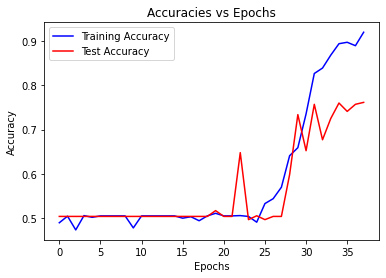

In [160]:
# plot accuracies
plt.plot(early_stop.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(early_stop.history['val_accuracy'], 'r', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies vs Epochs')
plt.legend()
plt.show()

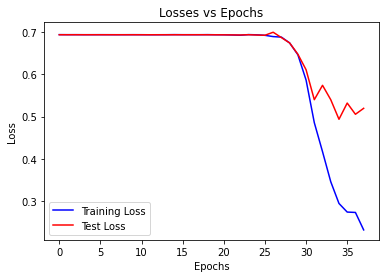

In [161]:
# plot losses
plt.plot(early_stop.history['loss'], 'b', label='Training Loss')
plt.plot(early_stop.history['val_loss'], 'r', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses vs Epochs')
plt.legend()
plt.show()

In [163]:
# evaluate model on validation set
val_acc = model.evaluate(X_val, y_val)[1]

17/17 [==============================] - 0s 2ms/step - loss: 0.5641 - accuracy: 0.7597


The test loss eventually became very low, which is good, however when evaluating on the holdout validation set the loss grew significantly.  The validation accuracy was very close to the testing accuracy which indicates the model would continue to make fairly decent predictions on future data.  Test and validation accuracies closer to the much higher training accuracies would be more desirable in order to say that the model would continue to make good predictions.  The fact that this happened indicates there is still some overfitting going on, and there remains room for improvement.

A wiser method of choosing nodes in each layer could be used instead of trial and error.  Grid search parameter optimization could be deployed along with more dense layers.  It would also be interesting to see if each of the 3 individual data sets resulted in differing performance.  Perhaps this could capture some subtle indication of differing voices amongst platform users.  Another thing to ponder is whether removing stop words and lemmatizing took away too much sentiment in the reviews.  Perhaps a model would perform better if more raw words were kept.  Either way 76% accuracy in prediction is a promising indication that, indeed, positive and negative customer sentiment can be extracted through natural language processing.

### Sources


DataCamp. (n.d.) Recurrent Nerual Networks for Language Modelling in Python.


DataCamp. (n.d.) Introduction to Deep Learning in Python.


An Introduction to Global Average Pooling in Convolutional Neural Networks.  (2019, May 23).  Adventures in Machine Learning.  http://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/


Python remove stop words from pandas dataframe. (n.d) Stack Overflow. https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe


Saxena, Sawan. (2020, Oct 3.)  Understanding Embedding Layer in Keras.  Analytics Vidhya. https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce


What is the role of "Flatten" in Keras? (n.d.) Stack Overflow. https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras


Sarma, Palash.  (2020, Oct 25).  Keras Dropout Layer Explained for Beginners.  MachineLearning Kowledge.ai.  https://machinelearningknowledge.ai/keras-dropout-layer-explained-for-beginners/